# Notebook to generate attention versus performance plots.

This notebook requires the processed behavior data for the triangle task, saved
in `../../../cache/behavior/triangle.csv`. This can be downloaded from the OSF
repo or can be generated by running the script
`../../../behavior_processing/run_cache_data.py`.

This notebook also requires the modeling results data, saved in
`../../cache/phys_modeling_logs/main`. This can be downloaded from the OSF
repo or can be generated by training the models yourself.

In [1]:
"""Imports."""

import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

import sys
sys.path.append('../../../behavior_processing')
import load_ring_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Load results."""

np.random.seed(0)  # For reproducibility
MODEL_CACHE_DIR = Path("../../../cache/modeling/main/ring_gain")
WRITE_DIR = Path('./plots')

# Load behavior data
df_behavior = load_ring_data.load_data()

# Make attention dataframe
df_attn = {
    "subject": [],
    "session": [],
    "seed": [],
    "num_neurons": [],
    "num_objects": [],
    "Performance": [],
    "Reaction time": [],
    "Target theta": [],
    "Target identity": [],
    "Target attention": [],
    "Nontarget theta": [],
    "Nontarget identity": [],
}
for subject_dir in MODEL_CACHE_DIR.iterdir():
    subject = subject_dir.name
    if subject.startswith("."):
        continue
    for session_dir in subject_dir.iterdir():
        session = session_dir.name
        if session.startswith("."):
            continue

        # Get behavior corresponding to this session
        df_behavior_session = df_behavior[
            (df_behavior["subject"] == subject) &
            (df_behavior["session"] == session)
        ]
        for seed_dir in session_dir.iterdir():
            seed = seed_dir.name
            if seed.startswith("."):
                continue

            # Load attention
            model_dir = MODEL_CACHE_DIR / subject / session / seed
            stop_step_dir = model_dir / "stop_step"
            attention_path = stop_step_dir / "model_cache" / "attention.npy"
            attention = np.load(attention_path)
            trial_num = np.load(stop_step_dir / "dataset_cache" / "trial_num.npy")
            train_metrics = json.load(open(model_dir / "train_metrics.json"))
            num_neurons = train_metrics[0]["num_neurons"]

            # Create behavior dataframe for these trials
            df_behavior_seed = df_behavior_session[df_behavior_session["trial_num"].isin(trial_num)].copy().reset_index(drop=True)
            if not np.array_equal(df_behavior_seed["trial_num"].values, trial_num):
                raise ValueError("Mismatched trial numbers")
            
            for row_index, row in df_behavior_seed.iterrows():
                num_objects = row["num_objects"]
                target_index = row["target_object_index"]
                target_theta = row[f"object_{target_index}_theta"]
                target_identity = row[f"object_{target_index}_id"]
                target_attention = attention[row_index, target_index]
                nontarget_index = 1 - target_index
                nontarget_theta = row[f"object_{nontarget_index}_theta"]
                nontarget_identity = row[f"object_{nontarget_index}_id"]

                # Update data
                df_attn["subject"].append(row["subject"])
                df_attn["session"].append(row["session"])
                df_attn["seed"].append(int(seed))
                df_attn["num_neurons"].append(num_neurons)
                df_attn["num_objects"].append(num_objects)
                df_attn["Performance"].append(row["correct"])
                df_attn["Reaction time"].append(1000 * row["reaction_time"])
                df_attn["Target theta"].append(target_theta)
                df_attn["Target identity"].append(target_identity)
                df_attn["Target attention"].append(target_attention)
                df_attn["Nontarget theta"].append(nontarget_theta)
                df_attn["Nontarget identity"].append(nontarget_identity)
df_attn = pd.DataFrame(df_attn)
df_attn["subject_session"] = df_attn["subject"] + "_" + df_attn["session"]
df_attn["subject_session_seed"] = df_attn["subject"] + "_" + df_attn["session"] + "_" + df_attn["seed"].astype(str)

# Compute performance dataframe with residuals
df_attn_performance = df_attn[
    (~df_attn["Target attention"].isna())
    & (df_attn["num_objects"] == 2)
].copy()
for subject_session_seed in df_attn_performance["subject_session_seed"].unique():
    df_session = df_attn_performance[df_attn_performance["subject_session_seed"] == subject_session_seed]
    target_theta = df_session["Target theta"].values
    target_id = df_session["Target identity"].values
    target_performance = df_session["Performance"].values
    target_attention = df_session["Target attention"].values
    
    # For each theta, compute means in a window around that theta
    residual_performance = []
    residual_attention = []
    num_trials = len(target_theta)
    window_size = 0.5 * np.pi
    for i in range(num_trials):
        # Get angular distance
        theta = target_theta[i]
        error = np.abs(target_theta - theta)
        error[error > np.pi] = 2 * np.pi - error[error > np.pi]
        error = np.abs(error)

        # Mask based on angular distance and identity
        mask = (error < window_size) & (target_id == target_id[i])
        mask[i] = False  # Exclude self
        mean_performance = np.nanmean(target_performance[mask])
        mean_attention = np.nanmean(target_attention[mask])
        residual_performance.append(target_performance[i] - mean_performance)
        residual_attention.append(target_attention[i] - mean_attention)
    
    # Add residuals to dataframe
    df_attn_performance.loc[df_session.index, "Residual performance"] = residual_performance
    residual_attention = np.array(residual_attention)
    residual_attention = (residual_attention - np.nanmean(residual_attention)) / np.std(residual_attention)
    df_attn_performance.loc[df_session.index, "Residual target attention"] = residual_attention

# Compute reaction time dataframe with residuals
df_attn_reaction_time = df_attn[
    (df_attn["Performance"])
    & (~df_attn["Target attention"].isna())
    & (df_attn["num_objects"] == 2)
].copy()
for subject_session_seed in df_attn_reaction_time["subject_session_seed"].unique():
    df_session = df_attn_reaction_time[df_attn_reaction_time["subject_session_seed"] == subject_session_seed]
    target_thetas = df_session["Target theta"].values
    target_ids = df_session["Target identity"].values
    target_reaction_time = df_session["Reaction time"].values
    target_attention = df_session["Target attention"].values
    
    # For each theta, compute means in a window around that theta
    residual_reaction_time = []
    residual_attention = []
    num_trials = len(target_thetas)
    window_size = 0.5 * np.pi
    for i in range(num_trials):
        # Get angular distance
        theta = target_thetas[i]
        error = np.abs(target_thetas - theta)
        error[error > np.pi] = 2 * np.pi - error[error > np.pi]
        error = np.abs(error)

        # Mask based on angular distance and identity
        mask = (error < window_size) & (target_ids == target_ids[i])
        mask[i] = False  # Exclude self
        mean_reaction_time = np.mean(target_reaction_time[mask])
        mean_attention = np.mean(target_attention[mask])
        residual_reaction_time.append(target_reaction_time[i] - mean_reaction_time)
        residual_attention.append(target_attention[i] - mean_attention)
    
    # Add residuals to dataframe
    df_attn_reaction_time.loc[df_session.index, "Residual reaction time"] = residual_reaction_time
    residual_attention = np.array(residual_attention)
    residual_attention = (residual_attention - np.mean(residual_attention)) / np.std(residual_attention)
    df_attn_reaction_time.loc[df_session.index, "Residual target attention"] = residual_attention

<>:58: SyntaxWarning: invalid escape sequence '\p'
<>:58: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_16763/2340654946.py:58: SyntaxWarning: invalid escape sequence '\p'
  f"$R={corr:.3f}$\n   $\pm {corr_sem:.3f}$",
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_16763/2340654946.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subject[f"Target attention binned"] = pd.cut(df_subject["Target attention"], bins=bin_edges, labels=bin_centers)
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_16763/2340654946.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Subject: Perle, R = 0.042335, corr_sem: 0.0033095233626589584, p-value: 2.5217385752084072e-37


/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  re

Subject: Elgar, R = 0.008828, corr_sem: 0.0033677036687328804, p-value: 0.006282750544393101


/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  re

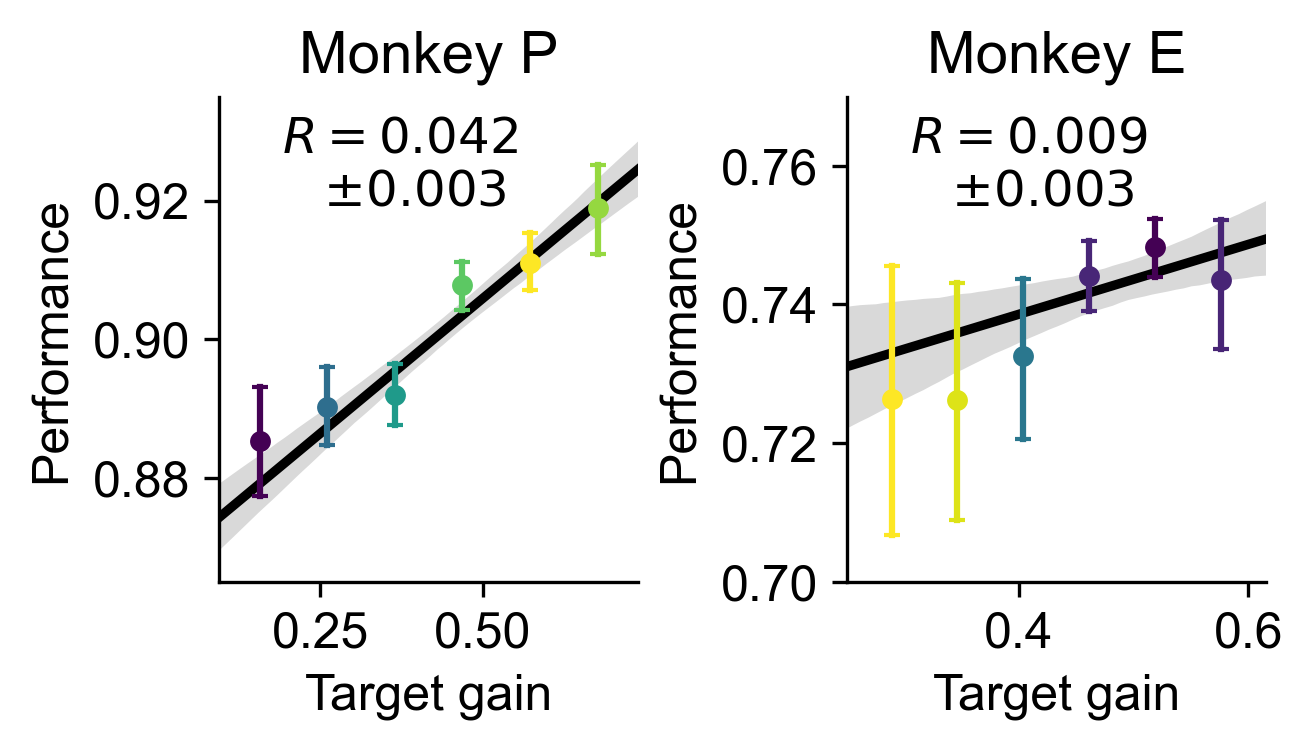

In [8]:
"""Performance plot."""

# Plot monkeys separately
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.1), gridspec_kw={'wspace': 0.5})
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    df_subject = df_attn_performance[df_attn_performance["subject"] == subject]

    # Plot regression
    x_min = np.quantile(df_subject["Target attention"], 0.03)
    x_max = np.quantile(df_subject["Target attention"], 0.97)
    sns.despine(ax=ax)
    
    # Bin attention
    bin_edges = np.linspace(x_min, x_max, 7)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    df_subject[f"Target attention binned"] = pd.cut(df_subject["Target attention"], bins=bin_edges, labels=bin_centers)

    # Make colormap based on target position
    df_subject["Target x"] = np.cos(df_subject["Target theta"])
    df_subject["Target y"] = np.sin(df_subject["Target theta"])
    mean_x = df_subject.groupby(f"Target attention binned")["Target x"].mean()
    mean_y = df_subject.groupby(f"Target attention binned")["Target y"].mean()
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(mean_x.min(), mean_x.max())
    colors = cmap(norm(mean_x))

    # Plot regression line
    sns.regplot(
        ax=ax,
        data=df_subject,
        x="Target attention",
        y="Performance",
        scatter=False,
        color='k',
    )

    # Compute correlation statistics
    x_vals = df_subject["Target attention"].values
    y_vals = df_subject["Performance"].values
    finite_mask = np.isfinite(x_vals) & np.isfinite(y_vals)
    x_vals = x_vals[finite_mask]
    y_vals = y_vals[finite_mask]
    num_points = len(df_subject)
    corr = pearsonr(x_vals, y_vals)[0]
    p_value = pearsonr(x_vals, y_vals)[1]
    n_bootstrap = 1000
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(np.arange(len(x_vals)), size=len(x_vals), replace=True)
        bootstrap_corrs.append(np.corrcoef(x_vals[indices], y_vals[indices])[0, 1])
    bootstrap_corrs = np.array(bootstrap_corrs)
    corr_sem = np.std(bootstrap_corrs)
    print(f"Subject: {subject}, R = {corr:8f}, corr_sem: {corr_sem}, p-value: {p_value}")

    # Add correlation text
    ax.text(
        0.15, 0.96,
        f"$R={corr:.3f}$\n   $\pm {corr_sem:.3f}$", 
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='left',
    )

    # Scatter performance for each attention bin
    for bin, color in zip(bin_centers, colors):
        df_bin = df_subject[df_subject[f"Target attention binned"] == bin]

        sns.lineplot(
            ax=ax,
            data=df_bin,
            x=f"Target attention binned",
            y="Performance",
            color=color,
            alpha=1,
            size=10,
            legend=False,
            marker='o',
            markeredgecolor='none',
            markersize=5,
            linestyle='',
            err_style='bars',
            err_kws=dict(capsize=2),
        )

    # Plot settings
    ax.set_title(f"Monkey {subject[0]}")
    ax.set_xlabel("Target gain")
    ax.set_ylabel("Performance")
    ax.set_xlim(x_min - 0.01, x_max + 0.01)
    if subject == "Perle":
        ax.set_ylim(0.865, 0.935)
    else:
        ax.set_ylim(0.7, 0.77)

# Save figure
fig.tight_layout()
WRITE_DIR.mkdir(parents=True, exist_ok=True)
write_path = WRITE_DIR / "performance.pdf"
fig.savefig(write_path, bbox_inches="tight", pad_inches=0.01)

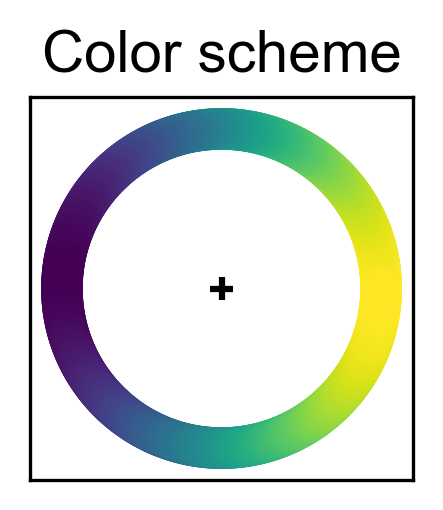

In [40]:
"""Plot color scheme."""

fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# Make points
theta = np.linspace(0, 2 * np.pi, 500)
x = np.cos(theta)
y = np.sin(theta)
colormap_df = pd.DataFrame({
    "x": x,
    "y": y,
    "theta": theta,
})

# Make color scheme based on target position
sns.scatterplot(
    ax=ax,
    data=colormap_df,
    x="x",
    y="y",
    hue="x",
    palette="viridis",
    s=100,
    marker='o',
    edgecolor='none',
    legend=False,
)

# Add short horizontal line at (0, 0)
cross_half_width = 0.07
ax.hlines(0, -cross_half_width, cross_half_width, color='k', linewidth=1.5)
ax.vlines(0, -cross_half_width, cross_half_width, color='k', linewidth=1.5)
ax.set_title("Color scheme")

# Save figure
fig.tight_layout()
WRITE_DIR.mkdir(parents=True, exist_ok=True)
write_path = WRITE_DIR / "colorscheme.pdf"
fig.savefig(write_path, bbox_inches="tight", pad_inches=0.01)